# Wybrany temat: 1
Przewidywanie ceny domów. Celem projektu jest zastosowanie modeli  regresji do przewidzenia ceny
domu o podanych cechach.

Link do danych: 
​
web.stanford.edu/class/stats191/data/ames2000_NAfix.csv

Dokładny opis danych: 
​
http://web.stanford.edu/class/stats191/data/amesdoc.txt

Zmienna celu (cena domu): SalePrice

Wymogi:

●
Musi zostać wykorzystany model regresji liniowej.

●
Muszą zostać wykorzystane przynajmniej dwie inne metody regresji: regresja Ridge, regresja
Lasso, drzewo regresyjne, las losowy regresyjny, XGBoost lub inne).

●
Trzeba uwzględnić optymalizację modeli/pipelinów.

●
Nie usuwamy żadnych obserwacji - braki danych uzupełniamy w jakiś sposób.

●
Wszelkie nieoczywiste przekształcenia danych należy opatrzyć uzasadnieniem dlaczego
dokonujemy tego przekształcenia (np. robimy wykres i uzasadniamy wzięcie logarytmu ze
zmiennej tym, że rozkład jest skośny).

●
Musi pojawić się ocena graficzna predykcji modeli (np. wykresy wartości przewidywanych od
prawdziwych czy wykresy reziduów).

●
Projekt musi być zakończony przejrzystym porównaniem przetestowanych rozwiązań
(modeli/pipelinów)w postaci tabeli, gdzie jeden wiersz opisuje jedno rozwiązanie i jego
wynik.

# Importy


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn import metrics
import warnings

# Zaczytanie danych i wstępna analiza


In [2]:
data = pd.read_csv('ames2000_NAfix.csv')
data.shape

(2000, 80)

 Dokumentacja opisuje bazę jako składającą się z 2930 obserwacji oraz 82 zmiennych. Brakujące kolumny to kolumny liczba porządkowa obserwacji oraz numer identyfikacyjny działki(nieistotne z punku widzenia modelu). Jeżeli chodzi o brakujące obserwacje to nazwa pliku wskazuje, że dane zostały już wstępnie oczyszczone z wartości pustych.

In [3]:
pd.set_option('display.max_columns', 80)
data.head(10)

,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Utilities,Lot.Config,Land.Slope,Neighborhood,Condition.1,Condition.2,Bldg.Type,House.Style,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Roof.Style,Roof.Matl,Exterior.1st,Exterior.2nd,Mas.Vnr.Type,Mas.Vnr.Area,Exter.Qual,Exter.Cond,Foundation,Bsmt.Qual,Bsmt.Cond,Bsmt.Exposure,BsmtFin.Type.1,BsmtFin.SF.1,BsmtFin.Type.2,BsmtFin.SF.2,Bsmt.Unf.SF,Total.Bsmt.SF,Heating,Heating.QC,Central.Air,Electrical,X1st.Flr.SF,X2nd.Flr.SF,Low.Qual.Fin.SF,Gr.Liv.Area,Bsmt.Full.Bath,Bsmt.Half.Bath,Full.Bath,Half.Bath,Bedroom.AbvGr,Kitchen.AbvGr,Kitchen.Qual,TotRms.AbvGrd,Functional,Fireplaces,Fireplace.Qu,Garage.Type,Garage.Yr.Blt,Garage.Finish,Garage.Cars,Garage.Area,Garage.Qual,Garage.Cond,Paved.Drive,Wood.Deck.SF,Open.Porch.SF,Enclosed.Porch,X3Ssn.Porch,Screen.Porch,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
0,120,RL,34,3901,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,Twnhs,1Story,6,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,Stone,182,Gd,TA,PConc,Gd,TA,Av,ALQ,866,Unf,0,436,1302,GasA,Ex,Y,SBrkr,1302,0,0,1302,1,0,1,1,1,1,Gd,5,Typ,1,Gd,Attchd,2005,RFn,2,631,TA,TA,Y,110,50,0,0,0,0,None,None,None,0,8,2007,New,Partial,204000
1,20,RL,70,8400,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,Nonemes,Norm,Norm,1Fam,1Story,4,5,1970,1970,Gable,CompShg,Plywood,Plywood,None,0,TA,TA,CBlock,TA,TA,No,ALQ,804,Rec,78,0,882,GasA,TA,Y,SBrkr,882,0,0,882,1,0,1,0,2,1,TA,4,Typ,0,None,Attchd,1970,Fin,2,525,TA,TA,Y,240,0,0,0,0,0,None,MnPrv,None,0,4,2010,WD,Normal,126000
2,85,RL,60,7200,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,SFoyer,5,8,1972,2003,Gable,CompShg,WdShing,HdBoard,None,0,TA,Gd,CBlock,Gd,TA,Av,GLQ,660,Unf,0,108,768,GasA,Gd,Y,SBrkr,768,0,0,768,0,1,1,0,2,1,TA,5,Typ,0,None,Detchd,1974,Fin,1,396,TA,TA,Y,192,0,0,0,0,0,None,MnPrv,None,0,4,2009,WD,Normal,133900
3,90,RL,64,7018,Pave,None,Reg,Bnk,AllPub,Inside,Gtl,SawyerW,Norm,Norm,Duplex,1Story,5,5,1979,1979,Gable,CompShg,Plywood,Plywood,None,0,TA,TA,Slab,None,None,None,None,0,None,0,0,0,GasA,TA,Y,SBrkr,1535,0,0,1535,0,0,2,0,4,2,TA,8,Typ,0,None,Attchd,1979,Unf,2,400,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,6,2009,WD,Alloca,118858
4,60,RL,111,16259,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,NridgHt,Norm,Norm,1Fam,2Story,9,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,Stone,370,TA,TA,PConc,Ex,Gd,Av,Unf,0,Unf,0,1249,1249,GasA,Ex,Y,SBrkr,1249,1347,0,2596,0,0,3,1,4,1,Gd,9,Typ,0,None,Attchd,2006,RFn,3,840,TA,TA,Y,240,154,0,0,0,0,None,None,None,0,9,2006,New,Partial,342643
5,20,RL,50,4280,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,4,9,1946,2001,Gable,CompShg,MetalSd,MetalSd,None,0,TA,Gd,CBlock,Fa,TA,No,Unf,0,Unf,0,560,560,GasA,Ex,Y,FuseA,704,0,0,704,0,1,1,0,2,1,Fa,4,Typ,0,None,CarPort,1946,Unf,1,220,TA,TA,Y,0,0,24,0,0,0,None,None,None,0,9,2009,WD,Normal,88750
6,20,RL,155,20064,Pave,None,IR1,Low,AllPub,Inside,Sev,ClearCr,Norm,Norm,1Fam,1Story,8,6,1976,1976,Shed,WdShngl,Wd Sdng,Wd Sdng,None,0,Gd,TA,CBlock,Gd,Gd,Gd,LwQ,51,GLQ,915,0,966,GasA,Ex,Y,SBrkr,1743,0,0,1743,2,0,0,1,0,1,Gd,5,Typ,2,Fa,Attchd,1976,Fin,2,529,TA,TA,Y,646,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,279000
7,20,RM,60,7200,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,4,5,1950,1950,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,576,576,GasA,Ex,Y,SBrkr,864,0,0,864,0,0,1,0,2,1,TA,5,Typ,0,None,Detchd,1952,RFn,1,528,TA,TA,Y,0,0,0,0,115,0,None,None,None,0,8,2006,COD,Normal,105000
8,20,RL,70,9100,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,7,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,244,Gd,TA,PConc,Gd,TA,Av,GLQ,1400,Unf,0,125,1525,GasA,Ex,Y,SBrkr,1525,0,0,1525,1,0,2,0,3,1,Gd,6,Typ,0,None,Attchd,2000,RFn,2,541,TA,TA,Y,219,36,0,0,0,0,None,None,None,0,9,2006,WD,Normal,235000
9,70,C (all),None,6449,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,SWISU,Norm,Norm,1Fam,2Story,4,1,1907,1950,Gambrel,CompShg,Wd Sdng,Stucco,None,0,TA,TA,CBlock,TA,TA,No,Rec,7

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   MS.SubClass      2000 non-null   int64 
 1   MS.Zoning        2000 non-null   object
 2   Lot.Frontage     2000 non-null   object
 3   Lot.Area         2000 non-null   int64 
 4   Street           2000 non-null   object
 5   Alley            2000 non-null   object
 6   Lot.Shape        2000 non-null   object
 7   Land.Contour     2000 non-null   object
 8   Utilities        2000 non-null   object
 9   Lot.Config       2000 non-null   object
 10  Land.Slope       2000 non-null   object
 11  Neighborhood     2000 non-null   object
 12  Condition.1      2000 non-null   object
 13  Condition.2      2000 non-null   object
 14  Bldg.Type        2000 non-null   object
 15  House.Style      2000 non-null   object
 16  Overall.Qual     2000 non-null   int64 
 17  Overall.Cond     2000 non-null   

In [5]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MS.SubClass,2000.0,56.9450,42.699281,20.0,20.00,50.0,70.00,190.0
Lot.Area,2000.0,10296.6650,8828.208491,1300.0,7500.00,9465.0,11500.00,215245.0
Overall.Qual,2000.0,6.0820,1.387169,1.0,5.00,6.0,7.00,10.0
Overall.Cond,2000.0,5.5740,1.105502,1.0,5.00,5.0,6.00,9.0
Year.Built,2000.0,1971.0795,29.985426,1872.0,1954.00,1972.0,2000.00,2010.0
Year.Remod.Add,2000.0,1984.0135,20.881771,1950.0,1965.00,1993.0,2004.00,2010.0
X1st.Flr.SF,2000.0,1158.7155,379.701015,407.0,877.75,1088.0,1391.25,4692.0
X2nd.Flr.SF,2000.0,334.3805,427.519973,0.0,0.00,0.0,703.25,2065.0
Low.Qual.Fin.SF,2000.0,4.3790,42.555738,0.0,0.00,0.0,0.00,697.0
Gr.Liv.Area,2000.0,1497.4750,498.561719,407.0,1126.75,1447.5,1734.00,5642.0


Można zauważyć, że w danych występują wartości puste. Należy zidentyfikować te kolumy i uzupełnić brakujące dane.

In [6]:
missing = len(data) - data.count()
missing[missing>0]



Mas.Vnr.Type      16
Bsmt.Qual          1
Bsmt.Cond          1
Bsmt.Exposure      3
BsmtFin.Type.1     1
BsmtFin.Type.2     2
Garage.Finish      2
Garage.Qual        1
Garage.Cond        1
dtype: int64

In [7]:
missing_cols = missing[missing>0].index

In [8]:
for column in data[missing_cols]:
    print(f'{column},: {data[column].unique()}')

Mas.Vnr.Type,: ['Stone' 'None' 'BrkFace' nan 'BrkCmn' 'CBlock']
Bsmt.Qual,: ['Gd' 'TA' 'None' 'Ex' 'Fa' nan 'Po']
Bsmt.Cond,: ['TA' 'None' 'Gd' 'Fa' 'Ex' nan 'Po']
Bsmt.Exposure,: ['Av' 'No' 'None' 'Gd' 'Mn' nan]
BsmtFin.Type.1,: ['ALQ' 'GLQ' 'None' 'Unf' 'LwQ' 'Rec' 'BLQ' nan]
BsmtFin.Type.2,: ['Unf' 'Rec' 'None' 'GLQ' 'ALQ' 'LwQ' 'BLQ' nan]
Garage.Finish,: ['RFn' 'Fin' 'Unf' 'None' nan]
Garage.Qual,: ['TA' 'None' 'Fa' 'Gd' nan 'Po' 'Ex']
Garage.Cond,: ['TA' 'None' 'Gd' 'Fa' 'Po' nan 'Ex']


In [9]:
df1 = data[data.isna().any(axis=1)]
df1[['Mas.Vnr.Type','Mas.Vnr.Area']]

,Mas.Vnr.Type,Mas.Vnr.Area
37,NaN,None
50,NaN,None
221,NaN,None
280,NaN,None
362,None,0
426,NaN,None
472,NaN,None
509,NaN,None
511,None,0
521,NaN,None


In [10]:
df1 = df1[pd.isna(df1['Mas.Vnr.Type'])]
print(len(df1))
df1[['Mas.Vnr.Type','Mas.Vnr.Area']]

16


,Mas.Vnr.Type,Mas.Vnr.Area
37,NaN,None
50,NaN,None
221,NaN,None
280,NaN,None
426,NaN,None
472,NaN,None
509,NaN,None
521,NaN,None
636,NaN,None
657,NaN,None


W przypdaku kolumn dotyczących garażu i piwnicy, braki dotyczą pojedynczych obserwacji. W przypadku zmiennej dotyczącej typu okleiny murarskiej, wszystki puste wartości odpowiadają wartością None w kolumnie "Mas.Vnr.Area" - można więc przyjąć, że dla tych 16 obserwacji nie występuje ta cecha. W związku z tym wszystkie puste wartości zostaną uzupełnione wartością None(zgodnie z dokumentajcą i opisem powyższych kolumn wskazującą brak cechy).

Dodatkowo przy okazji można zauważyć, że w kolumnie "Mas.Vnr.Area" występują wartości numeryczne oraz tekstowe. Następnym krokiem będzie więc analiza kolumn pod kątem poprawności znajdujących się tam danych.

In [11]:
data = data.fillna('None')


In [12]:
# Ponowne sprawdzenie
missing = len(data) - data.count()
missing[missing>0]

Series([], dtype: int64)

In [13]:
for column in data[missing_cols]:
    print(f'{column},: {data[column].unique()}')

Mas.Vnr.Type,: ['Stone' 'None' 'BrkFace' 'BrkCmn' 'CBlock']
Bsmt.Qual,: ['Gd' 'TA' 'None' 'Ex' 'Fa' 'Po']
Bsmt.Cond,: ['TA' 'None' 'Gd' 'Fa' 'Ex' 'Po']
Bsmt.Exposure,: ['Av' 'No' 'None' 'Gd' 'Mn']
BsmtFin.Type.1,: ['ALQ' 'GLQ' 'None' 'Unf' 'LwQ' 'Rec' 'BLQ']
BsmtFin.Type.2,: ['Unf' 'Rec' 'None' 'GLQ' 'ALQ' 'LwQ' 'BLQ']
Garage.Finish,: ['RFn' 'Fin' 'Unf' 'None']
Garage.Qual,: ['TA' 'None' 'Fa' 'Gd' 'Po' 'Ex']
Garage.Cond,: ['TA' 'None' 'Gd' 'Fa' 'Po' 'Ex']


In [14]:
# Weryfikacja danych w kolumnach
numeric = []
text = []
for column in data:
    if data[column].dtype == 'int64':
        numeric.append(column)
    elif data[column].dtype == 'O':
        text.append(column)
    else:
        print(column)

In [15]:
for column in data[numeric]:
    print(f'{column}: {data[column].unique()}')

MS.SubClass: [120  20  85  90  60  70  50  80 160 190  45  30  75 180  40 150]
Lot.Area: [ 3901  8400  7200 ... 10367 10142  7252]
Overall.Qual: [ 6  4  5  9  8  7 10  3  1  2]
Overall.Cond: [5 8 9 6 1 2 7 4 3]
Year.Built: [2005 1970 1972 1979 2006 1946 1976 1950 2000 1907 1918 1967 1931 1978
 1964 1958 2004 2007 1941 1954 2002 1959 1977 1998 1935 1984 1910 1965
 1960 1924 1966 1892 1988 1962 1929 1991 1956 1987 1975 2008 1996 1949
 1974 1900 1920 1955 1936 2001 1999 1928 1925 1981 1926 1993 1923 1992
 1947 1963 1922 1938 1961 2009 1968 1930 1971 1995 2003 1948 1997 1952
 1945 1921 1940 1872 1957 1985 1953 1937 1973 1880 1951 1990 1939 1983
 1980 1914 1919 1969 1895 1994 1890 1915 1916 1905 1942 1989 1908 1912
 1902 1986 2010 1917 1934 1927 1885 1879 1901 1932 1904 1982 1896 1911]
Year.Remod.Add: [2006 1970 2003 1979 2001 1976 1950 2000 1998 1967 1978 1964 2004 2007
 2005 1954 2002 1959 1977 1984 1981 1987 1973 1988 1966 1965 1985 1990
 1992 1956 2008 1997 1974 1993 1955 1980 1972 1975

In [16]:
for column in data[text]:
    
    print(f'{column}: {data[column].sort_values().unique()}')

MS.Zoning: ['A (agr)' 'C (all)' 'FV' 'I (all)' 'RH' 'RL' 'RM']
Lot.Frontage: ['100' '101' '102' '103' '104' '105' '106' '107' '108' '109' '110' '111'
 '112' '113' '114' '115' '116' '117' '118' '120' '121' '124' '125' '126'
 '128' '129' '130' '133' '134' '135' '136' '138' '140' '141' '149' '150'
 '152' '153' '155' '160' '168' '174' '182' '195' '21' '22' '24' '25' '26'
 '28' '30' '313' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42'
 '43' '44' '45' '46' '47' '48' '49' '50' '51' '52' '53' '54' '55' '56'
 '57' '58' '59' '60' '61' '62' '63' '64' '65' '66' '67' '68' '69' '70'
 '71' '72' '73' '74' '75' '76' '77' '78' '79' '80' '81' '82' '83' '84'
 '85' '86' '87' '88' '89' '90' '91' '92' '93' '94' '95' '96' '97' '98'
 '99' 'None']
Street: ['Grvl' 'Pave']
Alley: ['Grvl' 'None' 'Pave']
Lot.Shape: ['IR1' 'IR2' 'IR3' 'Reg']
Land.Contour: ['Bnk' 'HLS' 'Low' 'Lvl']
Utilities: ['AllPub']
Lot.Config: ['Corner' 'CulDSac' 'FR2' 'FR3' 'Inside']
Land.Slope: ['Gtl' 'Mod' 'Sev']
Neighborhood: ['Blmng

Widać, że występują kolejne kolumny zawierające liczby, ale zaklasyfikowane jako tekst. Do zrobienia uzupełnienie wartości None oraz przekonwertowanie kolumn na typ numeryczny.

In [17]:
'Lot.Frontage','Mas.Vnr.Area','BsmtFin.SF.1','BsmtFin.SF.2','Bsmt.Unf.SF','Total.Bsmt.SF','Garage.Yr.Blt','Garage.Cars','Garage.Area'

('Lot.Frontage',
 'Mas.Vnr.Area',
 'BsmtFin.SF.1',
 'BsmtFin.SF.2',
 'Bsmt.Unf.SF',
 'Total.Bsmt.SF',
 'Garage.Yr.Blt',
 'Garage.Cars',
 'Garage.Area')

Sprawdzono jakie wartości dla poszczególnych rekodów występją w kolumnach opisujących -> 'Bsmt.Qual' oraz 'Garage.Type' tj. sprawdzono czy w danych nieruchomościach w ogóle wystpują garaże i piwnice.

In [18]:
pd.set_option('display.max_rows', 80)
# df2 = data[data['BsmtFin.SF.1'] == 'None']
cols_bsmt = ['BsmtFin.SF.1','BsmtFin.SF.2','Bsmt.Unf.SF','Total.Bsmt.SF']
cols_gar = ['Garage.Yr.Blt','Garage.Cars','Garage.Area']
for column in cols_bsmt:
    df2 = data[data[column] == 'None']
    print(column)
    print(df2['Bsmt.Qual'])
for column in cols_gar:
    df2 = data[data[column] == 'None']
    print(column)
    print(df2['Garage.Type'])

BsmtFin.SF.1
682    None
Name: Bsmt.Qual, dtype: object
BsmtFin.SF.2
682    None
Name: Bsmt.Qual, dtype: object
Bsmt.Unf.SF
682    None
Name: Bsmt.Qual, dtype: object
Total.Bsmt.SF
682    None
Name: Bsmt.Qual, dtype: object
Garage.Yr.Blt
9       None
12      None
36      None
77      None
86      None
        ... 
1926    None
1949    None
1956    None
1974    None
1979    None
Name: Garage.Type, Length: 112, dtype: object
Garage.Cars
511    Detchd
Name: Garage.Type, dtype: object
Garage.Area
511    Detchd
Name: Garage.Type, dtype: object


In [19]:
df2 = data[data['Garage.Yr.Blt'] == 'None']
df2 = df2[['Garage.Yr.Blt','Garage.Type']]
df2.drop_duplicates()

,Garage.Yr.Blt,Garage.Type
9,None,None
362,None,Detchd


Po sprawdzeniu przyjmuję poniższe zasadu uzupełniania wartości:

Lot.Frontage - Linear feet of street connected to property - dane nie dopuszczają wartości 0 (kolumna oznacza odległość), braki uzupełnione średnią

Mas.Vnr.Area - Masonry veneer area in square feet - warosći uzupełnione zerem

BsmtFin.SF.1 - Type 1 finished square feet - braki dot. rekordu/nieruchomości bez piwnicy, uzupełnione zerem

BsmtFin.SF.2 -  Type 2 finished square feet- braki dot. rekordu/nieruchomości bez piwnicy, uzupełnione zerem

Bsmt.Unf.SF - Unfinished square feet of basement area- braki dot. rekordu/nieruchomości bez piwnicy, uzupełnione zerem

Total.Bsmt.SF - Total square feet of basement area- braki dot. rekordu/nieruchomości bez piwnicy, uzupełnione zerem

Garage.Yr.Blt - Year garage was built - braki dot. rekordu/nieruchomości zarówno z garażem jaki i bez garażu. Dla braku - zero, reszta - średnia

Garage.Cars - Size of garage in car capacity - brak dot. rekordu/nieruchomości z piwnicą, uzupełnone średnią

Garage.Area - Size of garage in square feet - brak dot. rekordu/nieruchomości z piwnicą, uzupełnone średnią

In [20]:
cols0 = ['BsmtFin.SF.1','BsmtFin.SF.2','Bsmt.Unf.SF','Total.Bsmt.SF','Mas.Vnr.Area']

for column in cols0:
    data[column] = np.where(data[column] == 'None','0',data[column])
    
cols_avg = ['Lot.Frontage','Garage.Cars','Garage.Area']
for column in cols_avg:
    without_none = data[data[column] != 'None'][column]
#     col_without_none = df_without_none[column]
    without_none = without_none.astype(int)
    data[column] = np.where(data[column] == 'None',np.average(without_none),data[column])
    
data['Garage.Yr.Blt'] = np.where(data[column] == 'None',np.average(without_none),data[column])

In [21]:
without_none = data[data['Garage.Yr.Blt'] != 'None']['Garage.Yr.Blt']
without_none = without_none.astype(int)

def fill_Garage(row):
    if row['Garage.Yr.Blt'] == 'None':
        if row['Garage.Type'] == "None":
            return '0'
        else:
            return np.median(without_none)
    else:
        return row['Garage.Yr.Blt']
        
data['Garage.Yr.Blt'] = data.apply( lambda row: fill_Garage(row), axis = 1)

In [22]:
ordinal_cols = ['Lot.Shape', 
                'Land.Slope', 
                'Exter.Cond', 
                'Exter.Qual', 
                'Bsmt.Cond', 
                'Bsmt.Qual', 
                'Electrical', 
                'Kitchen.Qual', 
                'Functional', 
                'Fireplace.Qu', 
                'Garage.Finish', 
                'Garage.Cond', 
                'Garage.Qual', 
                'Paved.Drive', 
                'Pool.QC', 
                'Fence']

ordinal_dicts = [{'Reg':0, 'IR1':1, 'IR2':2, 'IR3':3}, 
                 {'Gtl':0, 'Mod':1, 'Sev':2}, 
                 {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                 {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                 {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                 {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                 {'Mix':0, 'FuseP':1, 'FuseF':2, 'FuseA':3, 'SBrkr':4},
                 {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                 {'Typ':0, 'Min1':1, 'Min2':2, 'Mod':3, 'Maj1':4, 'Maj2':5, 'Sev':6, 'Sal':7},
                 {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                 {'None':0, 'Unf':1, 'RFn':2, 'Fin':3},
                 {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                 {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                 {'N':0, 'P':1, 'Y':2},
                 {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
                 {'None':0, 'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4}]


for column in ordinal_cols:
    for element in data[column].unique():
        data[column] = data[column].replace(element, ordinal_dicts[ordinal_cols.index(column)][element])

Dla reszty zamiana na wartości numeryczne odbędzie się za pomocą Label Encoding. Wybrano Label Encoding zamiast OneHot, z powodu sporej już zmiennych kolumn w danych i dużej ilości zmiennych opisowych. Dodatkowo zamierzam ograniczczyć ilość kolumn przeprowadzając analizę za pomocą PCA. PCA nie jest optymalnye dla kolumn binarnych, które są wynikiem kodowania algorytmem OneHot.

In [23]:
text = []
for column in data:
    if data[column].dtype == 'O':
        text.append(column)

In [24]:
for column in text:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype('str'))

In [25]:
# sprawdzenie rodzaju kolumn
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   MS.SubClass      2000 non-null   int64
 1   MS.Zoning        2000 non-null   int32
 2   Lot.Frontage     2000 non-null   int32
 3   Lot.Area         2000 non-null   int64
 4   Street           2000 non-null   int32
 5   Alley            2000 non-null   int32
 6   Lot.Shape        2000 non-null   int64
 7   Land.Contour     2000 non-null   int32
 8   Utilities        2000 non-null   int32
 9   Lot.Config       2000 non-null   int32
 10  Land.Slope       2000 non-null   int64
 11  Neighborhood     2000 non-null   int32
 12  Condition.1      2000 non-null   int32
 13  Condition.2      2000 non-null   int32
 14  Bldg.Type        2000 non-null   int32
 15  House.Style      2000 non-null   int32
 16  Overall.Qual     2000 non-null   int64
 17  Overall.Cond     2000 non-null   int64
 18  Year.Bui

Mimo, że nie będzie przeprowadzana głeboka analiza statyczna zmiennych w celu redukcji wymiarów, zbadano korelację zmiennych objaśniających do Ceny sprzedarzy, w celu wyrobienia intuicji dot. istotności poszczególnych kolumn. Niemniej jednak, redukcja wymiarów zostanie przeprowadzona poprzez PCA. 

In [26]:
corr = data.corr()
abs(corr['SalePrice']).sort_values(ascending = False)

SalePrice          1.000000
Overall.Qual       0.804547
Gr.Liv.Area        0.720922
Exter.Qual         0.691842
Kitchen.Qual       0.668868
X1st.Flr.SF        0.619121
Bsmt.Qual          0.616290
Garage.Cars        0.608635
Garage.Yr.Blt      0.583348
Garage.Area        0.583348
Year.Built         0.571716
Full.Bath          0.561228
Garage.Finish      0.559978
Year.Remod.Add     0.534962
Fireplace.Qu       0.532538
TotRms.AbvGrd      0.504280
Fireplaces         0.480794
Heating.QC         0.431059
Garage.Type        0.421114
Foundation         0.411287
Mas.Vnr.Area       0.374859
Bsmt.Exposure      0.337796
Wood.Deck.SF       0.329369
Open.Porch.SF      0.316206
X2nd.Flr.SF        0.295930
Half.Bath          0.287468
Lot.Shape          0.285217
Garage.Qual        0.269894
Paved.Drive        0.269316
Bsmt.Full.Bath     0.267416
Garage.Cond        0.262955
Central.Air        0.253711
Roof.Style         0.253390
Lot.Area           0.243990
Electrical         0.233829
Sale.Condition     0

Usunięto kolumny z danymi, których nie można pozyskać przed sprzedażą oraz 'Utilities', która przyjmuje tylko jedną wartość i nie ma wpływu na zmienną objaśnianą.

In [27]:
y = data['SalePrice']
data = data.drop(['SalePrice', 'Mo.Sold','Yr.Sold','Sale.Type','Sale.Condition', 'Utilities'], axis=1)

X=data

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

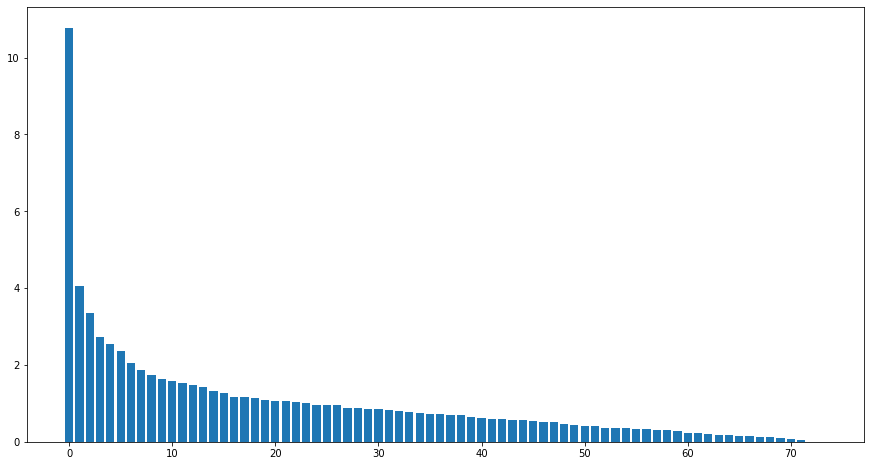

In [29]:
n_cols = len(data.columns)

# scaler = StandardScaler()
pca = PCA(n_cols)
pipeline = make_pipeline(StandardScaler(), pca)
pipeline.fit(X_train, y_train)
plt.figure(figsize=(15, 8))
plt.bar(range(pca.n_components_), pca.explained_variance_)
plt.show()



Jako że nie występuje widoczna granica, przyjęto 20 wymiarów jak bazę do analizy. Pozwoli to na zachowanie sporej czeście informacji jednocześnie znacznie zmiejszając czas obliczeń.

In [30]:
kfold = KFold(5, random_state=123)
pca = PCA(n_components=20, random_state=123)

c:\users\kucha\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [31]:
warnings.filterwarnings('ignore')

Na etapie modelowania przyjmowano szersze spektrum paramatrów niż finalnie zawarto w modelu, jeżeli najlepszy parametr to przyjmuje wartość graniczną z podanych ozacza to że dalsze zwiększanie/zmiejszanie paramatru dawało minimalne uzyski.

# LinearRegression

In [32]:
param_grid={'polynomialfeatures__degree': [1, 2, 3, 4]}

grid_1 = GridSearchCV(make_pipeline(StandardScaler(), pca, PolynomialFeatures(), LinearRegression()),
                    param_grid,
                    cv=kfold,
                    refit=True)

grid_1.fit(X_train, y_train)
grid_1.best_params_

{'polynomialfeatures__degree': 2}

In [33]:
print('R^2', metrics.r2_score(y_train, grid_1.predict(X_train)))
print('MAE',metrics.median_absolute_error(y_train, grid_1.predict(X_train)))
print('RMSE', np.sqrt(metrics.mean_squared_error(y_train, grid_1.predict(X_train))))
# metrics.r2_score(y_train, grid_1.predict(X_train))
# metrics.median_absolute_error(y_train, grid_1.predict(X_train))
# np.sqrt(metrics.mean_squared_error(y_train, grid_1.predict(X_train)))

R^2 0.9273665602262179
MAE 11820.175502821832
RMSE 20672.620907605822


# Lasso

In [34]:
param_grid={'polynomialfeatures__degree': [ 1, 2, 3, 4],
            'lasso__alpha': [300, 400, 500, 600, 700]}

grid_2 = GridSearchCV(make_pipeline(StandardScaler(), pca ,PolynomialFeatures(), pca, Lasso()),
                    param_grid,
                    cv=kfold,
                    refit=True)

grid_2.fit(X_train, y_train)
grid_2.best_params_

{'lasso__alpha': 500, 'polynomialfeatures__degree': 1}

In [35]:
print('R^2', metrics.r2_score(y_train, grid_2.predict(X_train)))
print('MAE',metrics.median_absolute_error(y_train, grid_2.predict(X_train)))
print('RMSE', np.sqrt(metrics.mean_squared_error(y_train, grid_2.predict(X_train))))

R^2 0.8128279737806667
MAE 17645.819622759613
RMSE 33185.449576676896


# Ridge

In [36]:
param_grid={'polynomialfeatures__degree': [1, 2, 3, 4],
                    'ridge__alpha': [1, 2, 3, 5, 7, 9, 12, 15]}

grid_3 = GridSearchCV(make_pipeline(StandardScaler(),pca, PolynomialFeatures(), Ridge()),
                    param_grid,
                    cv=kfold,
                    refit=True)
                      
grid_3.fit(X_train, y_train)
grid_3.best_params_
                      
          

{'polynomialfeatures__degree': 1, 'ridge__alpha': 15}

In [37]:
print('R^2', metrics.r2_score(y_train, grid_3.predict(X_train)))
print('MAE',metrics.median_absolute_error(y_train, grid_3.predict(X_train)))
print('RMSE', np.sqrt(metrics.mean_squared_error(y_train, grid_3.predict(X_train))))

R^2 0.813258914359437
MAE 17427.858915164514
RMSE 33147.22485321044


# Elastic Net

In [38]:
param_grid={'polynomialfeatures__degree': [1, 2, 3, 4],
                    'elasticnet__alpha': [0.5, 1, 2, 3, 4, 5, 6]}

grid_4 = GridSearchCV(make_pipeline(StandardScaler(), pca, PolynomialFeatures(), ElasticNet()),
                    param_grid,
                    cv=kfold,
                    refit=True)
grid_4.fit(X_train, y_train)
grid_4.best_params_

{'elasticnet__alpha': 0.5, 'polynomialfeatures__degree': 1}

In [39]:
print('R^2', metrics.r2_score(y_train, grid_4.predict(X_train)))
print('MAE',metrics.median_absolute_error(y_train, grid_4.predict(X_train)))
print('RMSE', np.sqrt(metrics.mean_squared_error(y_train, grid_4.predict(X_train))))

R^2 0.811753553353169
MAE 17232.544808327977
RMSE 33280.560219932304


# RandomForrest

In [40]:
param_grid={'n_estimators': [100, 150, 300],
            'max_features': ['auto', 'sqrt', 'log2'],
            'max_leaf_nodes': [ None, 2, 4, 8]}



grid_5 = GridSearchCV(RandomForestRegressor(),
                    param_grid,
                    cv=kfold,
                    refit=True,
                    n_jobs = -1)

grid_5.fit(X_train, y_train)
grid_5.best_params_

{'max_features': 'sqrt', 'max_leaf_nodes': None, 'n_estimators': 300}

In [41]:
print('R^2', metrics.r2_score(y_train, grid_5.predict(X_train)))
print('MAE',metrics.median_absolute_error(y_train, grid_5.predict(X_train)))
print('RMSE', np.sqrt(metrics.mean_squared_error(y_train, grid_5.predict(X_train))))

R^2 0.9841273866034569
MAE 4010.4816666666593
RMSE 9663.878339531926


# CatBoost

Użyty tu model zawiera już w sobie elementy preprocessingu, szczególnie jeżeli chodzi o obsługę zmiennych kategorycznych(użyte dane już są jednak całkowicie przekowertowane do warości numerycznych).

In [42]:
grid_6 = CatBoostRegressor()

param_grid = {'learning_rate': [0.03],
        'depth': [2, 4, 6],
        'l2_leaf_reg': [1, 2, 6]}

grid_best_result = grid_6.grid_search(param_grid, 
                                       X=X_train, 
                                       y=y_train,
                                       cv=5,
                                       plot=True)



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 25566.20206
bestIteration = 999

0:	loss: 25566.2020589	best: 25566.2020589 (0)	total: 1.86s	remaining: 14.9s

bestTest = 25741.6687
bestIteration = 954

1:	loss: 25741.6687033	best: 25566.2020589 (0)	total: 3.53s	remaining: 12.3s

bestTest = 26474.34625
bestIteration = 975

2:	loss: 26474.3462462	best: 25566.2020589 (0)	total: 5s	remaining: 10s

bestTest = 22588.44237
bestIteration = 980

3:	loss: 22588.4423655	best: 22588.4423655 (3)	total: 7.89s	remaining: 9.87s

bestTest = 23614.48557
bestIteration = 999

4:	loss: 23614.4855726	best: 22588.4423655 (3)	total: 10.9s	remaining: 8.71s

bestTest = 24300.45449
bestIteration = 997

5:	loss: 24300.4544851	best: 22588.4423655 (3)	total: 13.5s	remaining: 6.74s

bestTest = 24216.12968
bestIteration = 995

6:	loss: 24216.1296786	best: 22588.4423655 (3)	total: 19.3s	remaining: 5.52s

bestTest = 24607.76157
bestIteration = 999

7:	loss: 24607.7615671	best: 22588.4423655 (3)	total: 25s	remaining: 3.12s

bestTest = 24940.51656
bestIter

In [43]:
grid_6.get_best_score()

{'learn': {'RMSE': 11247.06303123934}}

In [44]:
models = []
models.append(('LR', grid_1.best_estimator_))
models.append(('Lasso', grid_2.best_estimator_))
models.append(('Ridge', grid_3.best_estimator_))
models.append(('Elastic Net', grid_4.best_estimator_))
models.append(('RF', grid_5.best_estimator_))
models.append(('CatBoost', grid_6))

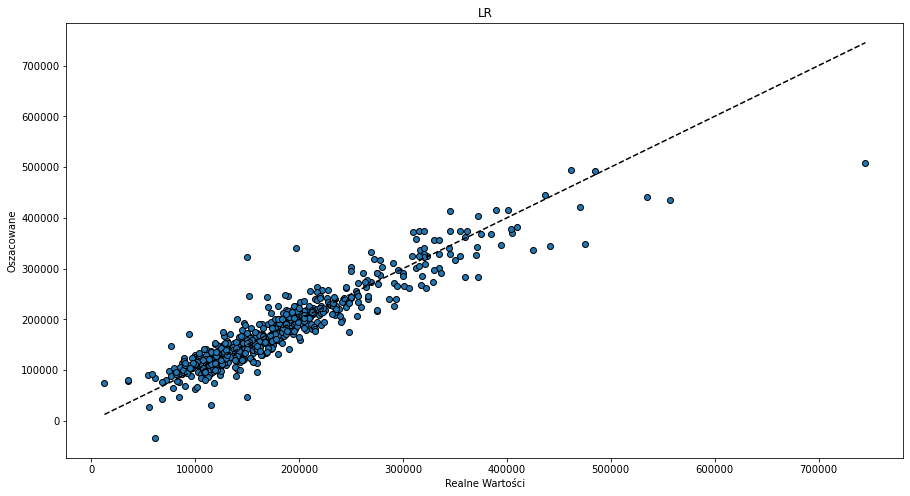

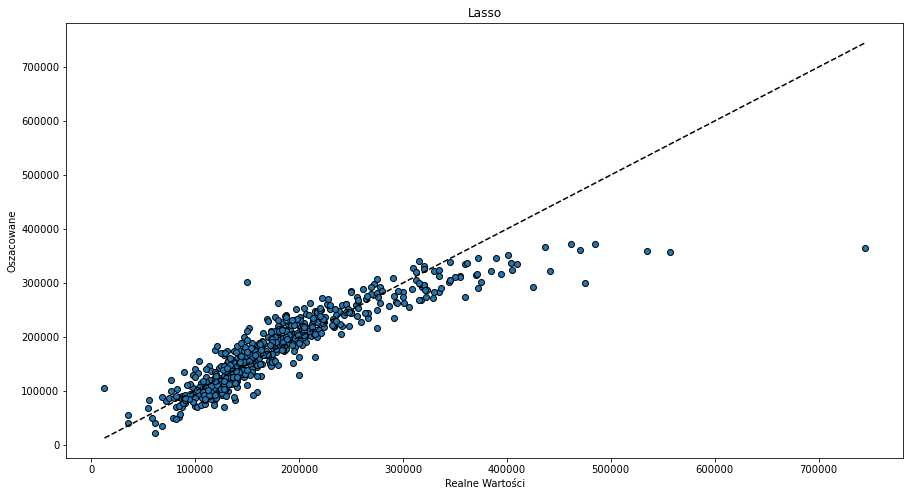

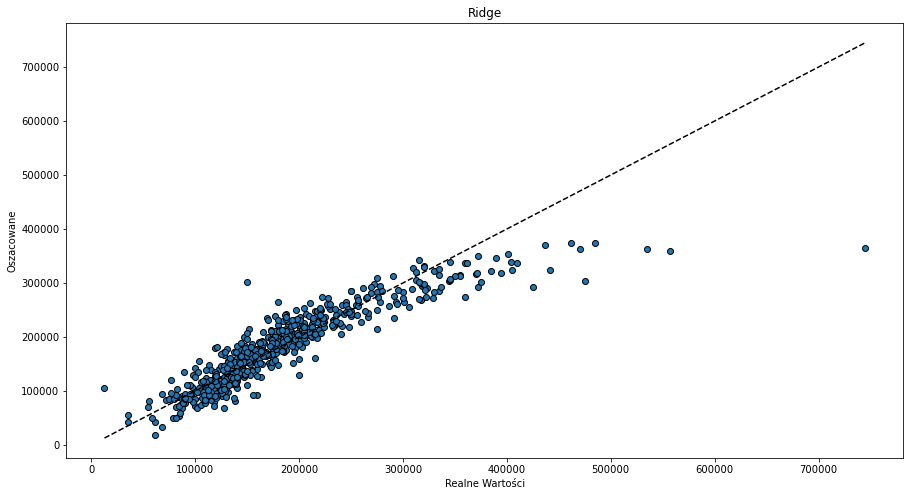

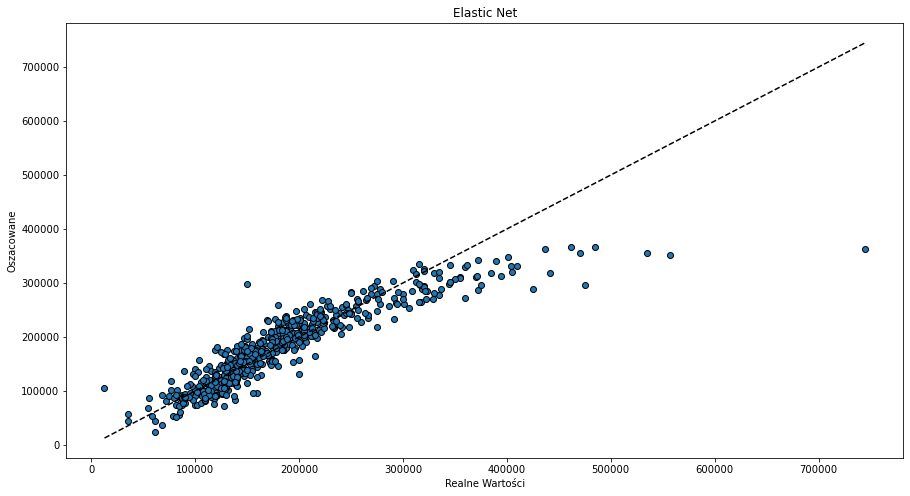

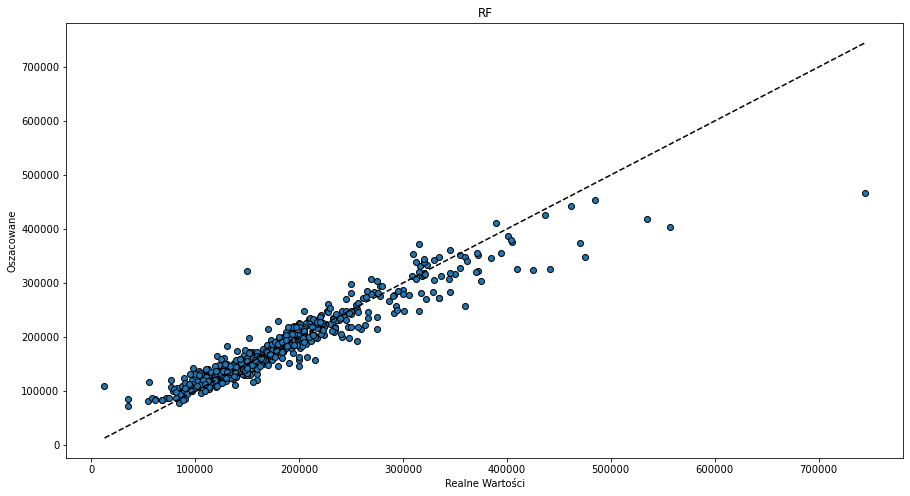

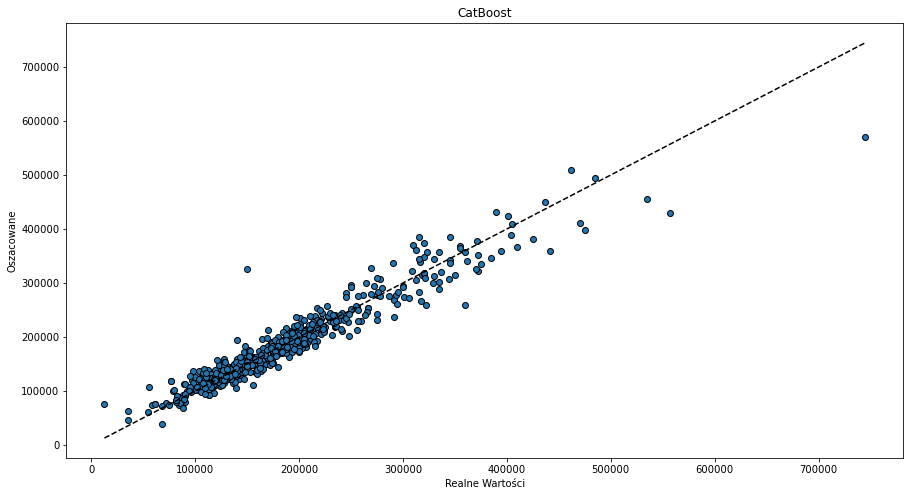

In [45]:
for name, model in models: 
    results = pd.DataFrame()
    results['actual'] = y_test
    results['predicted'] = model.predict(X_test)
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.scatter(results['actual'], results['predicted'], edgecolors=(0, 0, 0))
    ax.plot([results['actual'].min(), results['actual'].max()], [results['actual'].min(), results['actual'].max()], 'k--')
    ax.set_xlabel('Realne Wartości')
    ax.set_ylabel('Oszacowane')
    plt.title(name)
    plt.show()

In [46]:
rsme_score = []
names = []
r2_score = []
mae_score = []
for name, model in models:
    names.append(name)
    r2_score.append(metrics.r2_score(y_test, model.predict(X_test)))
    mae_score.append(metrics.median_absolute_error(y_test, model.predict(X_test)))
    rsme_score.append(np.sqrt(metrics.mean_squared_error(y_test, model.predict(X_test))))

In [47]:
final = pd.DataFrame(data=[r2_score, mae_score, rsme_score], columns = names)
final.rename(index={0: 'R^2', 1: 'MAE', 2: 'RSME'})

,LR,Lasso,Ridge,Elastic Net,RF,CatBoost
R^2,0.873812,0.817552,0.817098,0.815189,0.893714,0.925158
MAE,13153.069504,16625.582852,17133.660151,16539.630844,10246.426667,9352.431910
RSME,29244.852574,35164.887854,35208.663732,35391.894770,26839.709564,22522.364954


Najlepsze okazały się modele opate o algorytmy drzew decyzyjnych. Zawrówno RandomForestRegressor jak i CatBoost uzyskały najlepsze wyniki, Przy czym CatBoost okazał się nieco lepszy. Z pozostałych modeli najlepsze wyniki uzyskała Regresja liniowa. Pozostałe modele poradziły sobie słabiej, zwłasza jeżeli chodzi o nieruchomości o większęj cenie realnej - w większości modeli ceny były wtedy niedoszacowne.